In [5]:
from cryoS2Sdrop.analyze import *
from cryoS2Sdrop.deconvolution import tom_deconv_tomo
from skimage import exposure

PARENT_PATH = setup.PARENT_PATH

import matplotlib as mpl
from matplotlib.transforms import offset_copy
mpl.rc("image", cmap="viridis")

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Denoising comparison between tomograms and methods

## Helper functions

In [12]:
def paths2dataDict(pathDict):
    dataDict = []
    
    # as of 20.12 we used a different clipping for shrec, also gt_data needs to be processed differently
    if 'shrec' in pathDict['raw_path']:
        for x in tqdm(pathDict.keys()):
            if pathDict[x] is not None and x!='gt_path':
                val = clip(read_array(pathDict[x]), low=0.0005, high=0.9995)
                val = scale(standardize(val))
            elif pathDict[x] is not None and x=='gt_path':
                val = -1*read_array(pathDict[x])
                val = val - val.min()
                val = clip(val, low=0.0005, high=0.9995)
                val = scale(standardize(val))
            else:
                val = None
            
            dataDict.append(val)
                    
    else:
        for x in tqdm(pathDict.keys()):
            if pathDict[x] is not None:
                val = clip(read_array(pathDict[x]), low=0.005, high=0.995)
                val = scale(standardize(val))
            else:
                val = None  
                
            dataDict.append(val)
        
    dataDict = dict(zip(pathDict.keys(), dataDict))    
    
    
    return dataDict

# tomoPhantom
def get_tomoPhantom_dataDict(model_no=8):
    raw_path = '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model%i_noisyGaussPoissVL_Perlin.mrc' %model_no
    deconv_path = None
    cryoCARE_path = None
    N2V_path = "/home/ubuntu/Thesis/data/S2SDenoising/n2v_model_logs/tomoPhantom_model%i_noisyGaussPoissVL_Perlin/normal/tomoPhantom_model%i_noisyGaussPoissVL_Perlin_n2vDenoised.mrc" %(model_no, model_no)
    S2Sd_path = '/home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model%i_noisyGaussPoissVL_Perlin/structuredNoise_comparison/version_1/tomoPhantom_model%i_noisyGaussPoissVL_Perlin_s2sDenoised.mrc' %(model_no, model_no)
    F2Fd_path = '/home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model%i_noisyGaussPoissVL_Perlin/structuredNoise_comparison/version_0/tomoPhantom_model%i_noisyGaussPoissVL_Perlin_s2sDenoised.mrc' %(model_no, model_no)
    isoNet_path = None
    gt_path = '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model%i.mrc' %model_no
    
    pathDict = {
        'raw_path':raw_path,
        'deconv_path':deconv_path,
        'cryoCARE_path':cryoCARE_path,
        'N2V_path':N2V_path,
        'S2Sd_path':S2Sd_path,
        'F2Fd_path':F2Fd_path,
        'isoNet_path':isoNet_path,
        'gt_path':gt_path,
    }
    
    return paths2dataDict(pathDict)

# spinach
def get_spinach_dataDict(tomo_no=2):
    raw_path = '/home/ubuntu/Thesis/data/raw_cryo-ET/tomo%02i.mrc' %tomo_no
    deconv_path = '/home/ubuntu/Thesis/data/isoNet/RAW_dataset/RAW_allTomos_deconv/tomo%02i.mrc' %tomo_no
    cryoCARE_path = '/home/ubuntu/Thesis/data/nnUnet/nifti_files/tomo%02i_bin4_denoised_0000.nii.gz' %tomo_no
    N2V_path = '/home/ubuntu/Thesis/data/S2SDenoising/n2v_model_logs/tomo%02i/normal/tomo%02i_n2vDenoised.mrc' %(tomo_no, tomo_no)
    S2Sd_path = '/home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomo%02i/raw_denoising/version_1/tomo%02i_s2sDenoised.mrc' %(tomo_no, tomo_no)
    F2Fd_path = '/home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomo%02i/raw_denoising/version_0/tomo%02i_s2sDenoised.mrc' %(tomo_no, tomo_no)
    if tomo_no in [2, 4]:
        isoNet_path = '/home/ubuntu/Thesis/data/isoNet/single_image_RAW_dataset/tomo%02i/corrected/tomo%02i_corrected.mrc' %(tomo_no, tomo_no)
    else:
        print("WARNING: comparing to isoNet trained on many images.")
        isoNet_path = '/home/ubuntu/Thesis/data/isoNet/RAW_dataset/RAW_corrected/tomo%02i_corrected.mrc' %tomo_no
    gt_path = None
    
    pathDict = {
        'raw_path':raw_path,
        'deconv_path':deconv_path,
        'cryoCARE_path':cryoCARE_path,
        'N2V_path':N2V_path,
        'S2Sd_path':S2Sd_path,
        'F2Fd_path':F2Fd_path,
        'isoNet_path':isoNet_path,
        'gt_path':gt_path,
    }
    
    return paths2dataDict(pathDict)

In [36]:
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

def imshow_centralSlice(dataDict, key, axes, ax_index, axis, gt_key, use_dummyData=False):
    if use_dummyData:
        aux_data = dataDict[key][0:10]
        aux_gt_data = dataDict[gt_key][0:10]
    else:
        aux_data = dataDict[key]
        aux_gt_data = dataDict[gt_key]
    
    if aux_data is not None:
        
        idx_central_slices = np.array(aux_data.shape)//2
        aux_data = np.take(aux_data, idx_central_slices[axis], axis=axis)
        aux_gt_data = np.take(aux_gt_data, idx_central_slices[axis], axis=axis)
        
        a = axes[ax_index].imshow(aux_data)
        # a.axes.get_yaxis().set_visible(False)
        # a.axes.get_xaxis().set_visible(False)
        
        if key!=gt_key:
            _ssim = ssim(torch.tensor(aux_gt_data).unsqueeze(0).unsqueeze(0),
                         torch.tensor(aux_data).unsqueeze(0).unsqueeze(0), 
                         data_range=1)

            _psnr = peak_signal_noise_ratio(torch.tensor(aux_gt_data).unsqueeze(0).unsqueeze(0),
                         torch.tensor(aux_data).unsqueeze(0).unsqueeze(0), 
                         data_range=1)

            axes[ax_index].text(0.0125, 0.02, 'SSIM:%.02f' %float(_ssim), transform=axes[ax_index].transAxes, size=17, color='white')
            axes[ax_index].text(0.5, 0.02, 'PSNR:%.02f' %float(_psnr), transform=axes[ax_index].transAxes, size=17, color='white')
            # axes[ax_index].text(0.0125, 0.02, 'SSIM:%.02f' %float(0), transform=axes[ax_index].transAxes, size=17, color='white')
            # axes[ax_index].text(0.5, 0.02, 'PSNR:%.02f' %float(0), transform=axes[ax_index].transAxes, size=17, color='white')
        
    else:
        a = None
    
    return a

## Set 1

In [13]:
# tomoPhantom_dataDict = get_tomoPhantom_dataDict()
tomo04_dataDict = get_spinach_dataDict(tomo_no=4)
tomo02_dataDict = get_spinach_dataDict(tomo_no=2)

100%|█████████████████████████████████████████| 8/8 [02:18<00:00, 17.30s/it]


100%|████████████████████████████████████████| 6/6 [10:27<00:00, 104.66s/it]


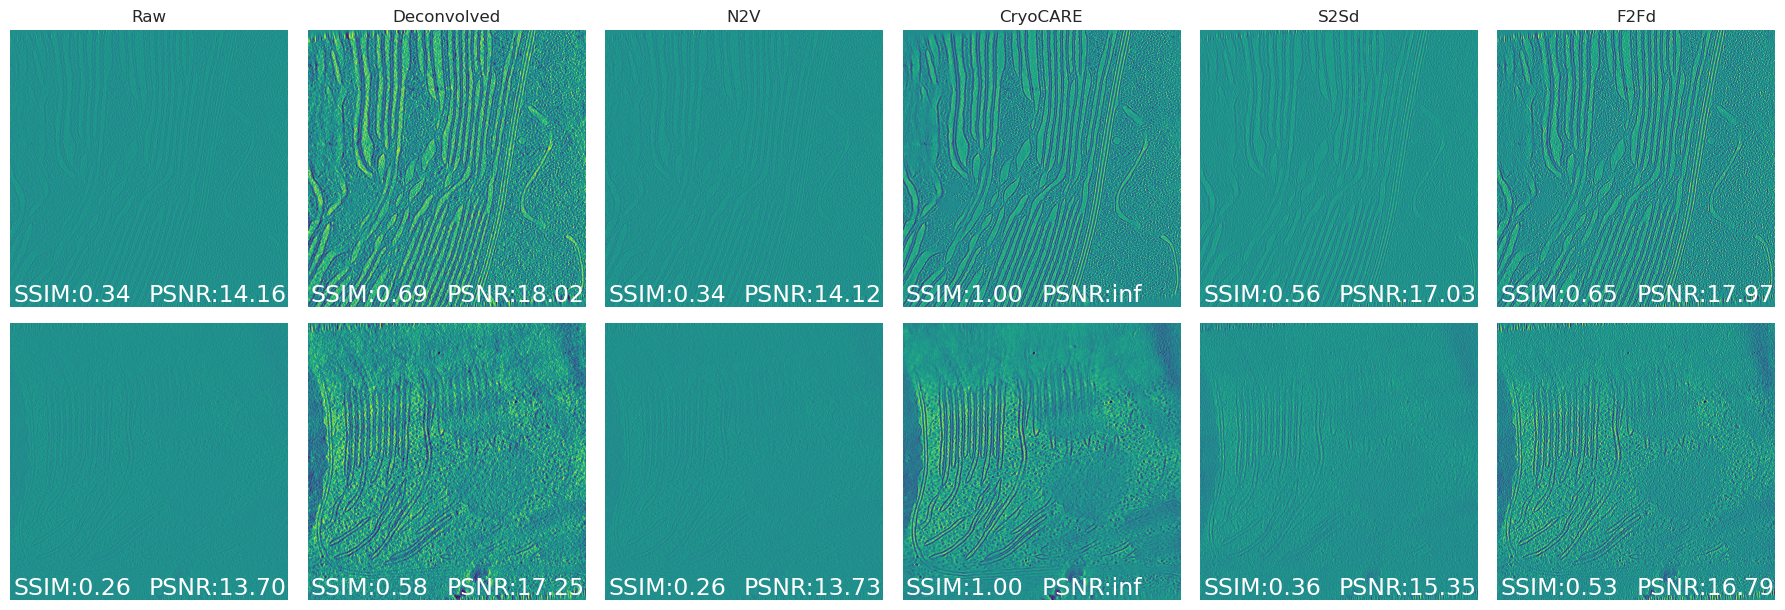

In [31]:
used_keys = ['raw_path', 'deconv_path', 'N2V_path', 'S2Sd_path', 'F2Fd_path', 'cryoCARE_path']

cols = ['Raw', 'Deconvolved', 'N2V', 'Real sampling', 'Fourier sampling', 'CryoCARE']
rows = ['Spinach Tomo02', 'Spinach Tomo04']

fig, ax = plt.subplots(2, len(used_keys), figsize=(18, 6), dpi=100)
# add_headers(fig, col_headers=cols, row_headers=rows)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
plt.tight_layout()

for axi, col in zip(ax[0], cols):
    axi.set_title(col)

tomo02_ax = ax[0]
tomo04_ax = ax[1]

i = 0
for idx, key in enumerate(tqdm(used_keys)):
    imshow_centralSlice(tomo02_dataDict, key, tomo02_ax, idx, 0, 'cryoCARE_path')
    imshow_centralSlice(tomo04_dataDict, key, tomo04_ax, idx, 0, 'cryoCARE_path')

100%|████████████████████████████████████████| 6/6 [00:00<00:00, 133.31it/s]


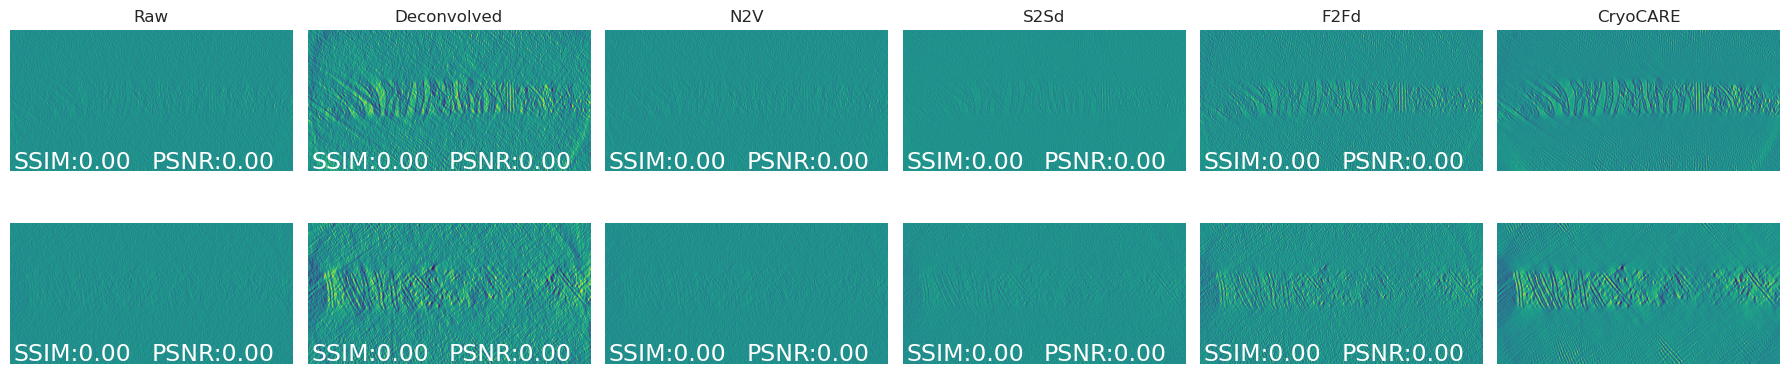

In [35]:
used_keys = ['raw_path', 'deconv_path', 'N2V_path', 'S2Sd_path', 'F2Fd_path', 'cryoCARE_path']

cols = ['Raw', 'Deconvolved', 'N2V', 'Real sampling', 'Fourier sampling', 'CryoCARE']
rows = ['Spinach Tomo02', 'Spinach Tomo04']

fig, ax = plt.subplots(2, len(used_keys), figsize=(18, 4), dpi=100)
# add_headers(fig, col_headers=cols, row_headers=rows)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
plt.tight_layout()

for axi, col in zip(ax[0], cols):
    axi.set_title(col)

tomo02_ax = ax[0]
tomo04_ax = ax[1]

i = 0
for idx, key in enumerate(tqdm(used_keys)):
    imshow_centralSlice(tomo02_dataDict, key, tomo02_ax, idx, 1, 'cryoCARE_path')
    imshow_centralSlice(tomo04_dataDict, key, tomo04_ax, idx, 1, 'cryoCARE_path')

## Set 2

In [6]:
tomoPhantom_dataDict = get_tomoPhantom_dataDict(14)
shrec_dataDict = get_shrec_dataDict(2)
spinach_dataDict = get_spinach_dataDict(17)

100%|█████████████████████████████████████████| 7/7 [02:06<00:00, 18.08s/it]


In [ ]:
used_keys = ['raw_path', 'deconv_path', 'cryoCARE_path', 'S2Sd_path', 'F2Fd_path', 'isoNet_path']

cols = ['Raw', 'Dimi', 'CryoCARE', 'S2Sd', 'F2Fd', 'IsoNet']
rows = ['TomoPhantom', 'SHREC', 'Spinach']

fig, ax = plt.subplots(3, len(used_keys), figsize=(18, 9), dpi=100)
# add_headers(fig, col_headers=cols, row_headers=rows)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
plt.tight_layout()

for axi, col in zip(ax[0], cols):
    axi.set_title(col)

tomoPhantom_ax = ax[0]
shrec_ax = ax[1]
spinach_ax = ax[2]

i = 0
for idx, key in enumerate(tqdm(used_keys)):
    imshow_centralSlice(tomoPhantom_dataDict, key, tomoPhantom_ax, idx, 0, 'gt_path')
    imshow_centralSlice(shrec_dataDict, key, shrec_ax, idx, 0, 'gt_path')
    imshow_centralSlice(spinach_dataDict, key, spinach_ax, idx, 0, 'cryoCARE_path')

100%|█████████████████████████████████████████| 6/6 [04:38<00:00, 46.48s/it]
